In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from sqlalchemy import create_engine
import numpy as np
import pathlib
from ccfwidget import CCFWidget
import ipywidgets as widgets

In [82]:
NUM_CHANNELS = 384

In [83]:
 # allow integers >8 bytes to be stored in sqlite3
sqlite3.register_adapter(np.int64, lambda val: int(val))
sqlite3.register_adapter(np.int32, lambda val: int(val))
# ------------------------------------------------------------------------------------
DB_PATH = pathlib.Path('//allen/programs/mindscope/workgroups/dynamicrouting/dynamic_gating_insertions/dr_master.db')
# with contextlib.suppress(OSError):
#     DB_PATH.unlink()
sqlite3.connect(DB_PATH).close()
DB = f"sqlite:///{DB_PATH}"
ENGINE = create_engine(DB, echo=False)

df_ccf = pd.read_sql('channel_ccf_coords', con=ENGINE)

In [84]:
implants = df_ccf['Implant'].unique()
implants

array(['41', 'football', 'TS1', 'TS5', '2002', 'templ',
       'Templeton/v1/0283-200-001'], dtype=object)

In [85]:
df_2002_ccf = df_ccf.loc[df_ccf['Implant'] == '2002']
area_counts = {}
area_trajectories = {}

for index, row in df_2002_ccf.iterrows():
    for i in range(NUM_CHANNELS):
        region_column = f'Channel_{i}_region'
        region = row[region_column]
        if region != 'out of brain' and region != 'root' and region != 'Track not annotated':
            if region in area_counts:
                area_counts[region] += 1
                area_trajectories[region].append(row.iloc[9:].to_numpy().reshape((384, 4))[:, 0:3]*25)
                break
            else:
                area_counts[region] = 1
                area_trajectories[region] = [row.iloc[9:].to_numpy().reshape((384, 4))[:, 0:3]*25]
                break

In [86]:
area_trajectories.keys()

dict_keys(['MD', 'LD', 'VPM', 'MB', 'PO', 'CP', 'AV', 'MRN', 'APN', 'RT', 'VPMpc', 'or', 'fi', 'LSr', 'CL', 'MGm', 'VAL', 'int', 'AMd', 'Eth', 'PoT', 'LSv', 'TH', 'GPe', 'LH', 'ar', 'VPL', 'chpl', 'DG-mo', 'POL', 'SF', 'fr', 'PF', 'PP', 'STR', 'SPA', 'LP', 'LGv', 'PIL', 'PVT', 'BST', 'ZI', 'LSc', 'PAG', 'PAL', 'CA1', 'PIR', 'ACB', 'PRE', 'MEPO', 'TTd', 'ORBl6a', 'MGv', 'CA3', 'PPN', 'SNr', 'RN', 'st', 'cpd', 'MGd', 'TMv', 'VM', 'aco', 'ACAv1', 'NPC', 'OT', 'MEA', 'PRNr', 'AQ', 'lot', 'OLF', 'P', 'MPO', 'fa', 'NDB', 'PVH', 'SI', 'ORBl2/3', 'AON', 'cing', 'PL6a', 'ccg', 'SEZ', 'MOs6b', 'DP'])

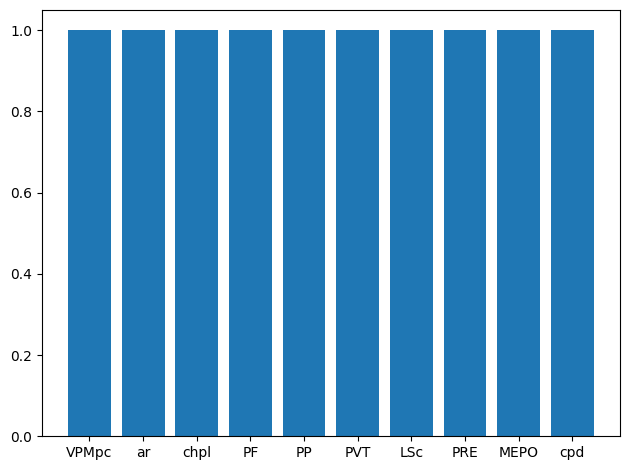

In [87]:
min_10_regions = sorted(area_counts.items(), key=lambda x:x[1])[0:10]
fig, ax = plt.subplots()
ax.bar([region[0] for region in min_10_regions], [region[1] for region in min_10_regions])
fig.tight_layout()
plt.show()

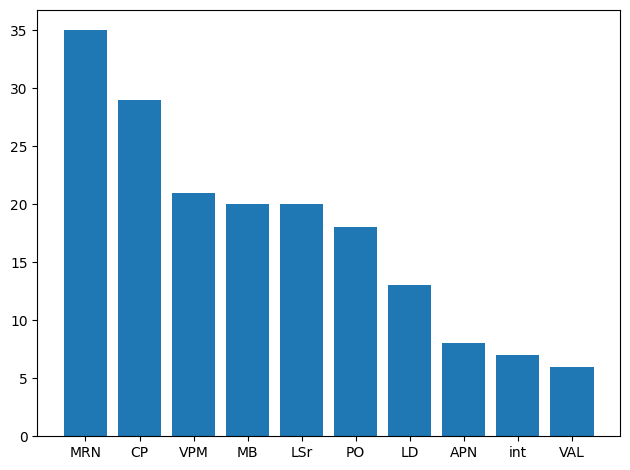

In [88]:
max_10_regions = sorted(area_counts.items(), key=lambda x:x[1], reverse=True)[0:10]
fig, ax = plt.subplots()
ax.bar([region[0] for region in max_10_regions], [region[1] for region in max_10_regions])
fig.tight_layout()
plt.show()

In [89]:
area_dropdown = widgets.Dropdown(
    options=list(area_trajectories.keys()),
    value=list(area_trajectories.keys())[0],
    description='CCF Area:',
    disabled=False,
)
area_dropdown

Dropdown(description='CCF Area:', options=('MD', 'LD', 'VPM', 'MB', 'PO', 'CP', 'AV', 'MRN', 'APN', 'RT', 'VPM…

In [90]:
w.value

'2'

In [91]:
area_of_interest = ['CP']
all_probes_areas = []

for area in area_of_interest:
    for area_trajectories_per_area in area_trajectories[area]:
        area_trajectories_per_area_filtered = area_trajectories_per_area[area_trajectories_per_area[:, 1] > 0]
        all_probes_areas.append(area_trajectories_per_area_filtered)


ccf = CCFWidget(markers=all_probes_areas, selected_acronyms=area_of_interest)
ccf

CCFWidget(children=(VBox(children=(Viewer(background=(0.85, 0.85, 0.85), camera=array([[ 1.3441567e+03, -2.172…